# DS 7333 - Quantifying the World
## Case Study #6: "Searching for Exotic Particles in High-Energy Physics with Deep Learning"¶

Sterling Beason, Sean Kennedy, Emil Ramos

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
from IPython.display import display
%matplotlib inline
# modeling
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
# sklearn helpers
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.base import BaseEstimator

import seaborn as sns

In [31]:
print(tf.__version__)

2.2.0


In [74]:
def do_model(name,
             features,
             labels,
             base_activation='tanh',
             epochs=200,
             batch_size=100):
    display(md(f"### {name}"))

    initial_learning_rate = 0.1
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=100000,
        decay_rate=0.9,
        staircase=True)
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

    # Partition data
    display(md("#### Partition Data"))
    X = features
    y = labels
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.20,
                                                        random_state=7333)
    print("done.")

    # Build model
    display(md("#### Build Model"))
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(300, activation=base_activation),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(300, activation=base_activation),
        tf.keras.layers.Dense(300, activation=base_activation),
        tf.keras.layers.Dense(300, activation=base_activation),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
    print("done.")

    # early stopping callback
    es = EarlyStopping(monitor="accuracy", min_delta=0.01, patience=4)

    display(md("#### Train Model"))
    # fit
    history = model.fit(X_train,
                        y_train,
                        validation_data=(X_test, y_test),
                        callbacks=[es],
                        epochs=epochs,
                        batch_size=batch_size)

    display(md("#### Train/Loss Plot (MSE)"))

    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='validation')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Training/Validation Curves')
    plt.show()

    # accuracy
    model_scores = model.evaluate(X_test, y_test, verbose=0)

    # AUC
    predictions = model.predict(X_test).ravel()  # predictions
    fpr, tpr, thresholds = roc_curve(y_test, predictions)  # ROC
    auc_metric = auc(fpr, tpr)  # finally AUC

    # print metrics
    display(md("#### Evaluate Model - Metrics"))
    print('Accuracy:', model_scores[1])
    print(f"AUC: {auc_metric}")
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
    #ROC curve
    p = sns.scatterplot(x=fpr,
                        y=tpr,
                        label=f'Keras NN: AUC {round(auc_metric, 3)}',
                        ax=ax)
    p.set_title('ROC Curve')
    fig.show()
    display(md(f"### ----------------------------------"))

    return (model_scores[1], auc_metric)

### Import Data

Subset to 1,000,000 rows so as to conserve training time

In [78]:
# import data
nrows = 10000000
data = pd.read_csv("./data/HIGGS.csv", nrows=nrows, header=None)
data[0] = data[0].astype(int)
print(f"Using {nrows:,.0f} rows of entire dataset")

Using 10,000,000 rows of entire dataset


### Data Description 


> The first column is the class label (1 for signal, 0 for background), followed by the 28 features (21 low-level features then 7 high-level features): lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb. For more detailed information about each feature see the original paper.



### Partition Data

- Low-level features

- High-level features

- All features

***We're running all three - why not? :)***

***The train test split will be 80/20 train/test*** 

### Researchers Model vs Ours


***Theirs***

**https://arxiv.org/pdf/1402.4735.pdf** 

(pg. 6)
>We selected a five-layer neural
network with 300 hidden units in each layer, a learning
rate of 0.05, and a weight decay coefficient of 1 × 10−5.

(pg. 9, Methods)
>Hidden units all used the tanh activation function.
Weights were initialized from a normal distribution with
zero mean and standard deviation 0.1 in the first layer,
0.001 in the output layer, and 0.05 all other hidden layers

(pg. 9, Methods)
>  Gradient computations were made on mini-batches
of size 100. A momentum term increased linearly over
the first 200 epochs from 0.9 to 0.99, at which point it
remained constant.

**Ours**

In this approach, we will model as closely as possible with the following models parameters.

- Keras Sequential NN
- Keras Optimizers (controls learning decay rate in our Stochastic Gradient Descent algorithm) 

The exponential decay of the learning rate at step n of the SGD search is controlled by the function:

$$LR_{n}=LR_{0}*D^\frac{n}{DS}$$


Where LR_n is the learning rate at step n, LR_0 is the initial learning rate, D is the decay rate and DS is the number of steps where the decay will be applied. This method is slightly different than that used by the researchers (see notes in summary/conclusion)

Since each of our epochs consists of 8000 steps, setting the learning rate decay steps = 10,000 will ensure decay in each step. 

We will match the inital learning rate of 0.05.

The researchers were able to set the initial weights of their layers according to specified normal (N($\mu,\sigma$)) distributions - keras dense layers do not seem to support that option out of the box so we will proceed with the default keras implementation which is random initialization. 

Our model will consist of:

- an implicit input layer (matching the dimensions of our feature set) 
- 4, 300 node dense tanh activation layers
- 1 50% probability drop out layer between the 1st and second dense layer
- 1 final layer with single node (sigmoid activation)

The drop out layer will serve as a regularization layer.

## TODO: discuss stopping




## TODO: discuss batch size effect

### Train Model

**https://arxiv.org/pdf/1402.4735.pdf**



### Low-level

#### Partition Data

done.


#### Build Model

done.


#### Train Model

Epoch 1/3
8000/8000 [==============================] - 28s 3ms/step - loss: 0.2410 - accuracy: 0.5735 - val_loss: 0.2336 - val_accuracy: 0.6037
Epoch 2/3
8000/8000 [==============================] - 27s 3ms/step - loss: 0.2330 - accuracy: 0.6053 - val_loss: 0.2263 - val_accuracy: 0.6244
Epoch 3/3
8000/8000 [==============================] - 27s 3ms/step - loss: 0.2275 - accuracy: 0.6223 - val_loss: 0.2209 - val_accuracy: 0.6394


#### Train/Loss Plot (MSE)

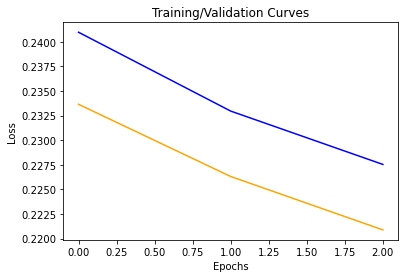

#### Evaluate Model - Metrics

Accuracy: 0.6394050121307373
AUC: 0.6917430455865092


c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:81: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


### ----------------------------------

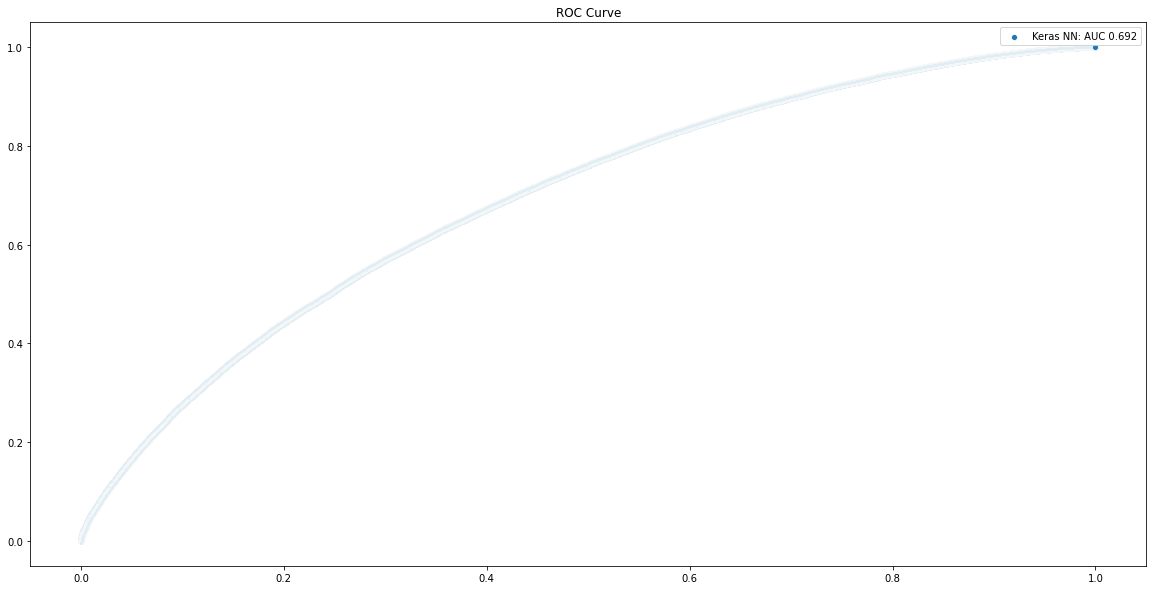

In [77]:
%matplotlib inline

compare_dict = {}

compare_dict["Low-level"] = do_model("Low-level",
                                     data.iloc[:, range(1, 22)].values,
                                     data[0].values)
compare_dict["High-level"] = do_model("High-level",
                                     data.iloc[:, range(22, 29)].values,
                                     data[0].values)
compare_dict["Mix-Low+High"] = do_model("Mix-Low+High",
                                     data.iloc[:, range(1, 29)].values,
                                     data[0].values)

***Any recommendations or modifications you’d make to the approach taken by the researchers (i.e., state any proposed changes along with the expected improvements or impact)***

>In training the neural networks, the following hyperparameters were predetermined without optimization

Keras classifiers can now be used with the same cross validation/grid search architecture found in sk-learn. Using that type of hyperparameter tuning could have been incredibly helpful had it been available to the researchers in this paper. Varying dropout rates, learning rates, weight decay, activation functions and network geometry (layers/depth) could have allowed them to search a much larger parameter space in an efficient way.

The researchers were also seemingly limited by the lack of cheap compute we currently enjoy today. The dataset used in their hyper parameter search (2.6mm training observations, 100k validation records) could have been expanded greatly given the increased availability of GPUs or perhaps even TPUs.

Additionally, many of the Keras optimization options were not available to the researchers. Useful classes such as [exponential_decay](https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/) could have saved them time coding those network features by hand. With that said, their "hands on" approach to learning rate decay allowed them more control over the overall decay process. Simply using the keras optimizers did not allow us to set sophisticated stopping criterion for the decay as the researchers did in their algorithm.

Additionally, while they mentioned adding a dropout layer for regularization/better generalization, they did not seem to implement this layer in their [code](https://github.com/uci-igb/higgs-susy/blob/master/higgs/layers4_width300_lr005_m200_wd000001_all.py)


***What are standard practices now versus when this paper was written?***  

Sigmoid or Relu instead of tanh

Random initialization of weights https://machinelearningmastery.com/why-initialize-a-neural-network-with-random-weights/


Adam as an optimizer

Pylearn2 is DEAD https://github.com/lisa-lab/pylearn2

***How would you quantify if your result duplicated the paper’s (hint: what evaluation metric did the researchers use)?***

- AUC match (possible)

- Weight match, tough given that pylearn2 doesn't work and weights are not published.
